In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#basics
import sys,os

#utils
import paths

#main libraries
import pandas as pd

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

In [3]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#model
from src.models import train_model
from src.models import evaluation

In [4]:
%%time
df_training,features,target = make_dataset.get_data(nrows=5000, low_memory=False, dataset="training")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 314 entries, id to target_kazutsugi
dtypes: float64(311), int32(1), object(2)
memory usage: 12.0+ MB
None
CPU times: user 763 ms, sys: 407 ms, total: 1.17 s
Wall time: 11.1 s


In [5]:
%%time
#df_tournament,features,target = make_dataset.get_data(nrows=5000, low_memory=False, dataset="tournament")

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.2 µs


In [6]:
memory_usage.memory()

Available memory (%): 16.248607635498047


In [7]:
results, res_cv = list(), dict()

In [8]:
rf_param_grid =  {
    'rf__n_estimators' : [10],
}


#encoding target to multiclass
lab_enc = preprocessing.LabelEncoder()
encoded_target_train = lab_enc.fit_transform(df_training[target])


#Group K-fold
CV = GroupKFold(n_splits = 3)
grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))


#scorer function
scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)

result = evaluation.evaluate_model(df_training[features], encoded_target_train,
                                   RandomForestClassifier(), 'rf',
                                   rf_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=grp,
                                   pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for rf model, 5000 examples
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


==> Elapsed seconds: 8.305
Best rf model: RandomForestClassifier(n_estimators=10)
Best rf score (val): 0.531


In [37]:
rf_param_grid =  {
    #'rf__bootstrap' : [True, False],
    #'rf__ccp_alpha' : 0.0, 
    #'rf__class_weight': [None, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, 'balanced'],
    #'rf__criterion' : 'gini', 
    #'rf__max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
    #'rf__max_features' : ['auto', 'sqrt'],
    #'rf__max_leaf_nodes' : None,
    #'rf__max_samples' : None,
    #'rf__min_impurity_decrease' : 0.0, 
    #'rf__min_impurity_split' : None,
    #'rf__min_samples_leaf' : [1, 2, 4],
    #'rf__min_samples_split' : [2, 5, 10],
    #'rf__min_weight_fraction_leaf' : 0.0, 
    'regrf__n_estimators' : [10, 20],#, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    #'rf__oob_score' : False, 
    #'rf__random_state' : None,
    #'rf__verbose' : 0, 
    #'rf__warm_start' : False
}


scorer = make_scorer(mean_squared_error)

result = evaluation.evaluate_model(df_training[features], encoded_target_train,
                                   RandomForestRegressor(), 'regrf',
                                   rf_param_grid, 
                                   scorer, n_iter=2, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for regrf model, 5000 examples
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    6.6s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   13.5s finished


==> Elapsed seconds: 17.852
Best regrf model: RandomForestRegressor(n_estimators=10)
Best regrf score (val): 2.135


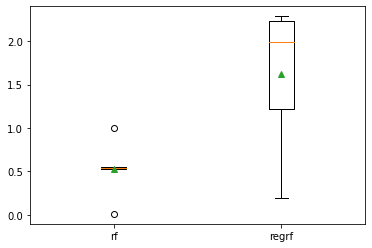

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

In [40]:
#salvando o pipeline completo
file_path = '../../models/rf-baseline-pipeline.pkl'

model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
model.save(file_path)

In [41]:
#salvando apenas o modelo
from joblib import dump, load
dump(model.model, '../../models/rf-baseline.pkl')

['../../models/rf-baseline.pkl']

In [ ]:
#carregando o modelo
model_loaded = load(file_path)

### 2a parte h20

In [7]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [8]:
h2o.init(ip = "localhost",
         port = 54321, #porta padrão
         nthreads = -1, #seleciona o máximo disponível
         max_mem_size="3g", #De acordo com a sua máquina
         name = "my-cluster")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_231"; Java(TM) SE Runtime Environment (build 1.8.0_231-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from /Users/nicholasrichers/Documents/virtualenvs/numerai_env/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/h3/qyfbykxs3jxflfr3kk8hdjcr0000gn/T/tmprb0lm3wx
  JVM stdout: /var/folders/h3/qyfbykxs3jxflfr3kk8hdjcr0000gn/T/tmprb0lm3wx/h2o_nicholasrichers_started_from_python.out
  JVM stderr: /var/folders/h3/qyfbykxs3jxflfr3kk8hdjcr0000gn/T/tmprb0lm3wx/h2o_nicholasrichers_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,6 days
H2O_cluster_name:,my-cluster
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.667 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [4]:
train_path = "https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz"
tournament_path = "https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz"

response = "target_kazutsugi"
file_path = '../../data/raw/numerai_training_data.csv'
tournament_path = '../../data/raw/numerai_tournament_data.csv'

In [7]:
df = h2o.import_file(path = file_path, sep=',', header=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
df.describe()

Rows:501808
Cols:314




,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,feature_charisma36,feature_charisma37,feature_charisma38,feature_charisma39,feature_charisma40,feature_charisma41,feature_charisma42,feature_charisma43,feature_charisma44,feature_charisma45,feature_charisma46,feature_charisma47,feature_charisma48,feature_charisma49,feature_charisma50,feature_charisma51,feature_charisma52,feature_charisma53,feature_charisma54,feature_charisma55,feature_charisma56,feature_charisma57,feature_charisma58,feature_charisma59,feature_charisma60,feature_charisma61,feature_charisma62,feature_charisma63,feature_charisma64,feature_charisma65,feature_charisma66,feature_charisma67,feature_charisma68,feature_charisma69,feature_charisma70,feature_charisma71,feature_charisma72,feature_charisma73,feature_charisma74,feature_charisma75,feature_charisma76,feature_charisma77,feature_charisma78,feature_charisma79,feature_charisma80,feature_charisma81,feature_charisma82,feature_charisma83,feature_charisma84,feature_charisma85,feature_charisma86,feature_strength1,feature_strength2,feature_strength3,feature_strength4,feature_strength5,feature_strength6,feature_strength7,feature_strength8,feature_strength9,feature_strength10,feature_strength11,feature_strength12,feature_strength13,feature_strength14,feature_strength15,feature_strength16,feature_strength17,feature_strength18,feature_strength19,feature_strength20,feature_strength21,feature_strength22,feature_strength23,feature_strength24,feature_strength25,feature_strength26,feature_strength27,feature_strength28,feature_strength29,feature_strength30,feature_strength31,feature_strength32,feature_strength33,feature_strength34,feature_strength35,feature_strength36,feature_strength37,feature_strength38,feature_dexterity1,feature_dexterity2,feature_dexterity3,feature_dexterity4,feature_dexterity5,feature_dexterity6,feature_dexterity7,feature_dexterity8,feature_dexterity9,feature_dexterity10,feature_dexterity11,feature_dexterity12,feature_dexterity13,feature_dexterity14,feature_constitution1,feature_constitution2,feature_constitution3,feature_constitution4,feature_constitution5,feature_constitution6,feature_constitution7,feature_constitution8,feature_constitution9,feature_constitution10,feature_constitution11,feature_constitution12,feature_constitution13,feature_constitution14,feature_constitution15,feature_constitution16,feature_constitution17,feature_constitution18,feature_constitution19,feature_constitution20,feature_constitution21,feature_constitution22,feature_constitution23,feature_constitution24,feature_constitution25,feature_constitution26,feature_constitution27,feature_constitution28,feature_constitution29,feature_constitution30,feature_constitution31,feature_constitution32,feature_constitution33,feature_constitution34,feature_constitution35,feature_constitution36,feature_constitution37,feature_constitution38,feature_constitution39,feature_constitution40,feature_constitution41,feature_constitution42,feature_constitution43,feature_constitution44,feature_constitution45,feature_constitution46,feature_constitution47,feature_constitution48,feature_con

In [8]:
#target como enum
df[response] = df[response].ascharacter().asfactor()
predictors = df.columns[3:-1]

In [9]:
#treinando o modelo
gbm = H2OGradientBoostingEstimator()
gbm.train(x=predictors, y=response, training_frame=df)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#uma forma melhor de representar a saida do modelo
gbm._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,era,20176.812500,1.000000,0.300251
1,feature_intelligence8,18633.714844,0.923521,0.277288
2,feature_intelligence4,6727.462891,0.333425,0.100111
3,feature_intelligence1,4635.756836,0.229757,0.068985
4,feature_dexterity11,1430.527588,0.070900,0.021288
...,...,...,...,...
306,feature_charisma22,2.660679,0.000132,0.000040
307,feature_strength30,1.781751,0.000088,0.000027
308,feature_wisdom45,1.602460,0.000079,0.000024
309,feature_charisma30,0.000000,0.000000,0.000000


In [12]:
# save the model
model_path = h2o.save_model(model=gbm, path="", force=True)
print(model_path)

/Users/nicholasrichers/Documents/GitHub/dissertacao/notebooks/Baseline/GBM_model_python_1597645189701_1


In [5]:
model_path = '/Users/nicholasrichers/Documents/GitHub/dissertacao/notebooks/Baseline/GBM_model_python_1597645189701_1'

In [9]:
# load the model
saved_model = h2o.load_model(model_path)

In [10]:
#carregando o dataset de teste
df_tournament = h2o.import_file(path = tournament_path, sep=',', header=1)
df_tournament[response] = df_tournament[response].ascharacter().asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
%%time
predictors = df_tournament.columns[3:-1]
preds = saved_model.predict(df_tournament[predictors])

gbm prediction progress: |████████████████████████████████████████████████| 100%
CPU times: user 566 ms, sys: 173 ms, total: 739 ms
Wall time: 1min 32s


In [ ]:
#save preds csv

# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = df_tournament["id"]
predictions_df["prediction_kazutsugi"] = preds['predict']


In [24]:
predictions_df

id,prediction_kazutsugi
n0003aa52cab36c2,0.25
n000920ed083903f,0
n0038e640522c4a6,1
n004ac94a87dc54b,0.75
n0052fe97ea0c05f,0.25
n00a5ccf3b6b2870,1
n00bf78d0bbbc1b6,0.5
n00c6fd95ff0c83e,0.5
n00cd56868258aec,0.75
n00e7d6fb71ef69f,0.5


In [27]:
#salvar direto pelo h2o cria "" nos pares chave e valor, melhor converter pra pandas

#h2o.h2o.download_csv(predictions_df, 'preds.csv')

'/Users/nicholasrichers/Documents/GitHub/dissertacao/notebooks/Baseline/preds.csv'

In [32]:
#converte pra pandas e salva o csv
predictions_df = predictions_df.as_data_frame()
predictions_df.to_csv("predictions.csv", index=False)

### 3a parte Pycaret

melhor guia: https://towardsdatascience.com/announcing-pycaret-2-0-39c11014540e

In [9]:
from pycaret.classification import *

In [28]:
lab_enc = preprocessing.LabelEncoder()
encoded_target_train = lab_enc.fit_transform(df_training[target])

In [29]:
df = df_training[features].copy()
df[target] = encoded_target_train.copy()

In [25]:
import lightgbm

In [30]:
ml_setup = setup(data=df, target=target, train_size=0.8, session_id=1234)

Setup Succesfully Completed!


,Description,Value
0,session_id,1234
1,Target Type,Multiclass
2,Label Encoded,None
3,Original Data,"(5000, 311)"
4,Missing Values,False
5,Numeric Features,310
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [31]:
compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.2685,0.0000,0.2687,0.2665,0.2662,0.0857,0.0859,32.3979
1,Ada Boost Classifier,0.2630,0.0000,0.2632,0.2615,0.2612,0.0788,0.0790,7.6529
2,Naive Bayes,0.2518,0.0000,0.2516,0.2471,0.2374,0.0644,0.0662,0.1698
3,Logistic Regression,0.2513,0.0000,0.2515,0.2503,0.2500,0.0641,0.0642,1.5162
4,Ridge Classifier,0.2428,0.0000,0.2430,0.2425,0.2417,0.0535,0.0536,0.3013
5,Linear Discriminant Analysis,0.2427,0.0000,0.2430,0.2429,0.2422,0.0535,0.0536,1.6980
6,CatBoost Classifier,0.2418,0.0000,0.2419,0.2409,0.2405,0.0522,0.0523,51.6827
7,Extreme Gradient Boosting,0.2402,0.0000,0.2404,0.2398,0.2398,0.0503,0.0503,35.2291
8,Light Gradient Boosting Machine,0.2402,0.0000,0.2404,0.2397,0.2395,0.0503,0.0504,6.0065
9,Extra Trees Classifier,0.2302,0.0000,0.2303,0.2292,0.2294,0.0378,0.0378,4.2059


OneVsRestClassifier(estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=

In [32]:
dt_model = create_model(estimator=imator='rf', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2375,0.0000,0.2377,0.2380,0.2347,0.0471,0.0475
1,0.2262,0.0000,0.2263,0.2256,0.2238,0.0329,0.0330
2,0.2262,0.0000,0.2264,0.2254,0.2232,0.0330,0.0333
3,0.2262,0.0000,0.2264,0.2282,0.2240,0.0329,0.0332
4,0.2175,0.0000,0.2176,0.2204,0.2169,0.0219,0.0220
Mean,0.2268,0.0000,0.2269,0.2275,0.2245,0.0336,0.0338
SD,0.0064,0.0000,0.0064,0.0058,0.0057,0.0080,0.0081


In [33]:
predict_model(dt_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,One Vs Rest Classifier,0.236,0,0.2359,0.2365,0.2341,0.0451,0.0453


,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi,Label,Score
0,0.25,0.00,0.00,0.25,0.00,1.00,1.00,0.25,0.25,0.25,...,0.75,0.50,0.50,0.00,0.75,0.25,0.75,1,1,0.2778
1,0.25,0.50,0.50,0.50,0.25,0.25,0.25,0.25,0.50,0.50,...,1.00,1.00,1.00,0.25,1.00,1.00,1.00,4,4,0.2857
2,0.75,0.50,0.25,0.25,0.00,1.00,1.00,0.25,0.25,0.25,...,0.75,1.00,1.00,1.00,0.75,0.75,1.00,3,3,0.2667
3,0.75,0.50,0.25,0.50,0.00,1.00,1.00,0.75,0.00,0.00,...,0.25,0.00,0.50,0.00,0.00,0.75,1.00,3,0,0.3333
4,0.00,0.50,0.50,0.00,0.25,0.00,0.00,0.00,1.00,0.75,...,0.25,0.25,0.75,0.75,0.00,1.00,1.00,2,2,0.4167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.00,1.00,0.75,0.25,0.25,0.75,0.75,0.25,0.75,0.75,...,1.00,1.00,1.00,1.00,1.00,0.50,0.75,4,2,0.3077
996,0.50,0.75,1.00,0.50,0.75,0.75,0.75,1.00,0.75,0.50,...,0.25,0.25,0.00,0.00,0.25,0.50,0.25,1,3,0.3077
997,0.75,0.25,0.25,0.75,0.00,1.00,1.00,0.75,0.25,0.25,...,0.25,0.50,0.75,0.75,0.25,0.75,1.00,2,3,0.4167
998,0.00,0.25,0.25,0.25,0.25,0.00,0.00,0.00,0.25,0.25,...,0.50,0.25,0.25,0.00,0.50,0.50,0.50,0,4,0.5556


In [38]:
tuned_dt = tune_model(estimator=dt_model, fold=5, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2300,0.0000,0.2300,0.2283,0.2284,0.0374,0.0375
1,0.2488,0.0000,0.2487,0.2485,0.2482,0.0609,0.0609
2,0.2475,0.0000,0.2476,0.2473,0.2466,0.0594,0.0595
3,0.2638,0.0000,0.2638,0.2599,0.2610,0.0797,0.0798
4,0.2412,0.0000,0.2412,0.2397,0.2398,0.0515,0.0516
Mean,0.2462,0.0000,0.2463,0.2448,0.2448,0.0578,0.0579
SD,0.0110,0.0000,0.0110,0.0105,0.0107,0.0137,0.0138


In [39]:
predict_model(tuned_dt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,One Vs Rest Classifier,0.234,0,0.2338,0.2331,0.2333,0.0424,0.0424


,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi,Label,Score
0,0.25,0.00,0.00,0.25,0.00,1.00,1.00,0.25,0.25,0.25,...,0.75,0.50,0.50,0.00,0.75,0.25,0.75,1,3,0.2475
1,0.25,0.50,0.50,0.50,0.25,0.25,0.25,0.25,0.50,0.50,...,1.00,1.00,1.00,0.25,1.00,1.00,1.00,4,0,0.2435
2,0.75,0.50,0.25,0.25,0.00,1.00,1.00,0.25,0.25,0.25,...,0.75,1.00,1.00,1.00,0.75,0.75,1.00,3,4,0.2641
3,0.75,0.50,0.25,0.50,0.00,1.00,1.00,0.75,0.00,0.00,...,0.25,0.00,0.50,0.00,0.00,0.75,1.00,3,0,0.3098
4,0.00,0.50,0.50,0.00,0.25,0.00,0.00,0.00,1.00,0.75,...,0.25,0.25,0.75,0.75,0.00,1.00,1.00,2,2,0.3728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.00,1.00,0.75,0.25,0.25,0.75,0.75,0.25,0.75,0.75,...,1.00,1.00,1.00,1.00,1.00,0.50,0.75,4,2,0.3050
996,0.50,0.75,1.00,0.50,0.75,0.75,0.75,1.00,0.75,0.50,...,0.25,0.25,0.00,0.00,0.25,0.50,0.25,1,3,0.2418
997,0.75,0.25,0.25,0.75,0.00,1.00,1.00,0.75,0.25,0.25,...,0.25,0.50,0.75,0.75,0.25,0.75,1.00,2,3,0.3050
998,0.00,0.25,0.25,0.25,0.25,0.00,0.00,0.00,0.25,0.25,...,0.50,0.25,0.25,0.00,0.50,0.50,0.50,0,1,0.3111


In [40]:
evaluate_model(tuned_dt)

,Parameters
estimator__bootstrap,True
estimator__ccp_alpha,0
estimator__class_weight,None
estimator__criterion,gini
estimator__max_depth,30
estimator__max_features,sqrt
estimator__max_leaf_nodes,None
estimator__max_samples,None
estimator__min_impurity_decrease,0
estimator__min_impurity_split,None


In [41]:
print(tuned_dt)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=30,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=4,
                                                     min_samples_split=9,
                                                     min_weight_fraction_leaf=0.0,
                                              

In [42]:
final_dt_tuned = finalize_model(tuned_dt)

In [ ]:
save_model(final_dt_tuned, 'random_forest_model')

In [43]:
print(final_dt_tuned)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=30,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=4,
                                                     min_samples_split=9,
                                                     min_weight_fraction_leaf=0.0,
                                              

In [5]:
#interpret_model(final_dt_tuned)

Rascunho

In [ ]:
%%time
#from joblib import parallel_backend

#with parallel_backend('threading', n_jobs=-1):
    # Train the model
    #model = RandomForestClassifier(n_estimators=10, n_jobs=-1)
    #model.fit(df_training[features], encoded_target_train)
    # Test the model
    #y_pred = clf.predict(X_test)
